In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, select
from sqlalchemy import Column, Integer, String, Float, Date, ForeignKey

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()


Base.prepare(autoload_with = engine)

# reflect the tables
station = Base.classes.station
measurement = Base.classes.measurement

# Create our session (link) from Python to the DB
session = Session(bind= engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
inspector = inspect(engine)
# inspector.get_table_names() # getting the name of table

# getting all the columns name from measurement
columns_measure = inspector.get_columns("measurement")
print("Table: measurement")
for column in columns_measure:
    print(column["name"], column["type"])

print("-------------------------------")

columns_station = inspector.get_columns("station")
print("Table: Station")
for column in columns_station:
    print(column["name"], column["type"])

Table: measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-------------------------------
Table: Station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Save references to each table


In [9]:
# Create our session (link) from Python to the DB



# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
# .all() is required to show the results and is not for exporting to datafrme
recent_date = session.query(func.max(measurement.date)).all()
recent_date = recent_date[0][0]
recent_date

'2017-08-23'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# getting the first date and the last day using datetime
from datetime import datetime

last_date_obj = datetime.strptime(recent_date, "%Y-%m-%d")
first_date_obj = last_date_obj.replace(year= 2016)

last_date = last_date_obj.strftime("%Y-%m-%d")
first_date = first_date_obj.strftime("%Y-%m-%d")

# To extract the date and prcp columns from measurement table, .query(table_name.col1, table_name.col2)
# and the filter out the data I wanted, .filter(table_name.col.xxxx(conditions))
last_12_month_prcp= session.query(measurement.date, measurement.prcp).filter(measurement.date.between(first_date,last_date))

# convert the query into dataframe
last_12_month_df = pd.read_sql(last_12_month_prcp.statement, engine)
last_12_month_df.head()

,date,prcp
0,2016-08-23,0.0
1,2016-08-24,2.0
2,2016-08-25,2.0
3,2016-08-26,0.0
4,2016-08-27,0.0


In [12]:
# formatting the date column using pd.to_datetime
last_12_month_df["date"] = pd.to_datetime(last_12_month_df["date"], format= "%Y-%m-%d")

# Sort the dataframe by date
last_12_month_sort = last_12_month_df.sort_values(by= "date", ascending= True)
last_12_month_sort.head()

,date,prcp
0,2016-08-23,0.0
1009,2016-08-23,NaN
1529,2016-08-23,45.5
704,2016-08-23,1.3
361,2016-08-23,3.8


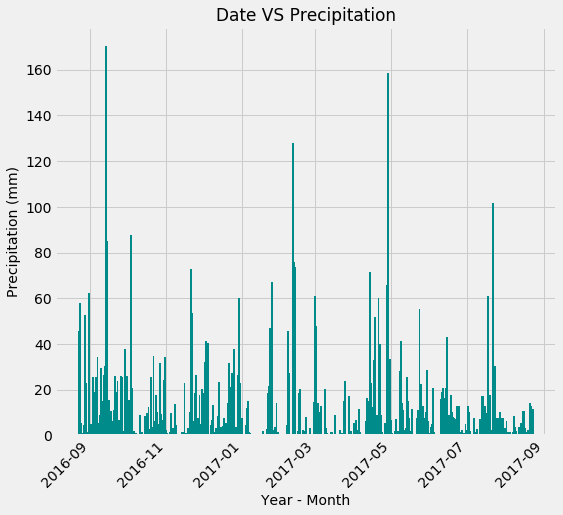

In [13]:
plt.figure(figsize=(8, 7))
plt.grid(zorder=0)
plt.bar(last_12_month_sort["date"], last_12_month_sort["prcp"], color= "darkcyan", width= 1.5)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Year - Month", fontsize=14)
plt.ylabel("Precipitation (mm)", fontsize=14)
plt.title("Date VS Precipitation", fontsize=17)


plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_month_df.describe()

,prcp
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
stations_total_count = session.query(station.station).count()
print(f"The total number of stations in Hawaii is {stations_total_count}")

The total number of stations in Hawaii is 9


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(measurement.station.desc()).all()

# finding the most active station using a simple for loop
most_active_station_count = 0
for count in active_stations:
    print(count)
    if count[1] > most_active_station_count:
        most_active_station_count = count[1]
        most_active_station = count[0]

print(f"The station ID of most active station is {most_active_station}.")

('USC00519523', 2669)
('USC00519397', 2724)
('USC00519281', 2772)
('USC00518838', 511)
('USC00517948', 1372)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00513117', 2709)
('USC00511918', 1979)
The station ID of most active station is USC00519281.


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#  the lowest temp
lowest_temp = session.query(measurement.tobs, func.min(measurement.tobs)).filter(measurement.station == most_active_station).first()
print(f"The lowest temperature in station {most_active_station} is {lowest_temp[0]}")

# calculate highest temp
highest_temp = session.query(measurement.tobs, func.max(measurement.tobs)).filter(measurement.station == most_active_station).first()
print(f"The highest temperature in station {most_active_station} is {highest_temp[0]}")

#calculate average temp
avg_temp = session.query(measurement.tobs, func.avg(measurement.tobs)).filter(measurement.station == most_active_station).all()
print(f"The average temperature in station {most_active_station} is {avg_temp[0][1]}")

The lowest temperature in station USC00519281 is 12.2
The highest temperature in station USC00519281 is 29.4
The average temperature in station USC00519281 is 22.03582251082252


In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
last_12_month_temp = session.query(measurement.date, measurement.tobs).filter(measurement.station == most_active_station).filter(measurement.date.between(first_date,last_date))
last_12_month_temp_df = pd.read_sql(last_12_month_temp.statement, engine)
last_12_month_temp_df

,date,tobs
0,2016-08-23,25.0
1,2016-08-24,25.0
2,2016-08-25,26.7
3,2016-08-26,26.7
4,2016-08-27,23.9
...,...,...
347,2017-08-14,25.0
348,2017-08-15,25.0
349,2017-08-16,24.4
350,2017-08-17,24.4


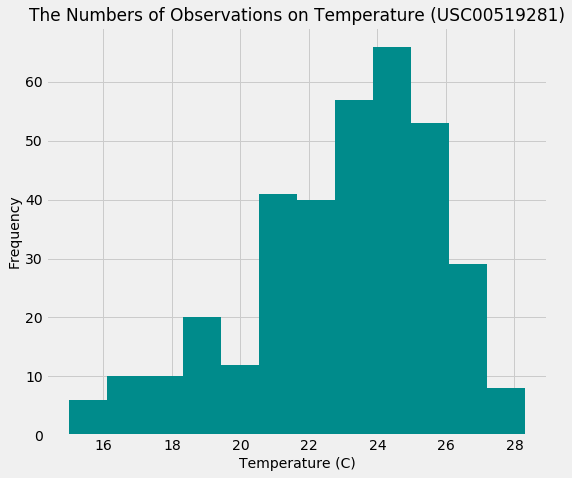

In [19]:
# plot a histogram for the last 12 months of temperature observation data for this station 
plt.figure(figsize=(8, 7))
plt.grid(zorder=0)
plt.hist(last_12_month_temp_df["tobs"], color= "darkcyan", bins=12)

plt.xlabel("Temperature (C)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("The Numbers of Observations on Temperature (USC00519281)", fontsize=17)


plt.show()

# Close session

In [20]:
# Close Session
session.close()